In [70]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib
import keras

from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [58]:
df = pd.read_csv('cleangreenhousesnippet.csv')
df.index = df['%time']
df.drop('%time', axis=1, inplace=True)
df.head()

,CO2air,co2_dos
%time,,
43815.00347,501,0.00030
43815.00694,489,0.00040
43815.01042,497,0.00200
43815.01389,477,0.00160
43815.01736,492,0.00110


In [60]:
print(df.dtypes)
df = df.dropna()
df['CO2air'] = pd.to_numeric(df['CO2air'], errors='coerce')
df['co2_dos'] = pd.to_numeric(df['co2_dos'], errors='coerce')

CO2air     float64
co2_dos    float64
dtype: object


In [61]:
df.head()

,CO2air,co2_dos
%time,,
43815.00347,501.00000,0.00030
43815.00694,489.00000,0.00040
43815.01042,497.00000,0.00200
43815.01389,477.00000,0.00160
43815.01736,492.00000,0.00110


<Axes: xlabel='%time'>

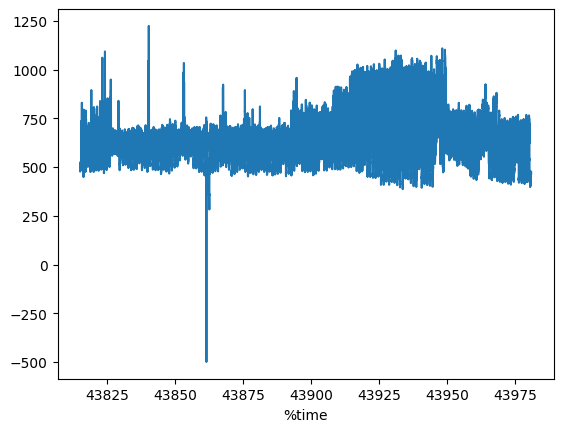

In [62]:
co2air = df['CO2air']
co2air.plot()

<Axes: xlabel='%time'>

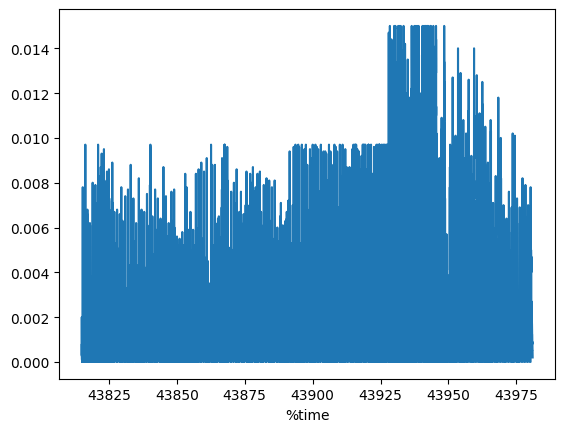

In [63]:
co2dos = df['co2_dos']
co2dos.plot()

In [64]:
def df_to_X_y(df, window_size=10):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i + window_size]]
        X.append(row)
        label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1]]
        y.append(label)
    return np.array(X), np.array(y)

In [65]:
X, y = df_to_X_y(df)
X.shape, y.shape

((47727, 10, 2), (47727, 2))

In [66]:
X_train, y_train = X[:35000], y[:35000]
X_val, y_val = X[35000:40000], y[35000:40000]
X_test, y_test = X[40000:], y[40000:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((35000, 10, 2),
 (35000, 2),
 (5000, 10, 2),
 (5000, 2),
 (7727, 10, 2),
 (7727, 2))

In [67]:
co2_training_mean = np.mean(X_train[:, :, 0])
co2_training_std = np.std(X_train[:, :, 0])

co2dos_training_mean = np.mean(X_train[:, :, 1])
co2dos_training_std = np.std(X_train[:, :, 1])

def preprocess3(X):
  X[:, :, 0] = (X[:, :, 0] - co2_training_mean) / co2_training_std
  X[:, :, 1] = (X[:, :, 1] - co2dos_training_mean) / co2dos_training_std

def preprocess_output3(y):
  y[:, 0] = (y[:, 0] - co2_training_mean) / co2_training_std
  y[:, 1] = (y[:, 1] - co2dos_training_mean) / co2dos_training_std
  return y

In [68]:
preprocess3(X_train)
preprocess3(X_val)
preprocess3(X_test)

preprocess_output3(y_train)
preprocess_output3(y_val)
preprocess_output3(y_test)

array([[ 0.4794384 , -0.8877938 ],
       [ 0.63133818, -0.8877938 ],
       [ 0.64821593, -0.8877938 ],
       ...,
       [-1.54589198, -0.79854396],
       [-1.47838097, -0.79854396],
       [-1.46150322, -0.79854396]])

In [78]:
X_train.shape, y_train.shape

((35000, 10, 2), (35000, 2))

In [79]:
model4 = Sequential()
model4.add(InputLayer((10, 2)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(2, 'linear'))

model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,690 (69.10 KB)

 Trainable params: 17,690 (69.10 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
cp4 = ModelCheckpoint('model4/greenhousetest.keras', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [81]:
model4.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=20, callbacks=[cp4])

Epoch 1/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6844 - root_mean_squared_error: 0.8228 - val_loss: 0.4825 - val_root_mean_squared_error: 0.6946
Epoch 2/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2365 - root_mean_squared_error: 0.4853 - val_loss: 0.2001 - val_root_mean_squared_error: 0.4474
Epoch 3/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0949 - root_mean_squared_error: 0.3078 - val_loss: 0.0986 - val_root_mean_squared_error: 0.3141
Epoch 4/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0594 - root_mean_squared_error: 0.2436 - val_loss: 0.0790 - val_root_mean_squared_error: 0.2811
Epoch 5/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0528 - root_mean_squared_error: 0.2298 - val_loss: 0.0715 - val_root_mean_squared_error: 0.2674
Epoch 6/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0476 - root_mean_squared_error: 0.2182 - val_loss: 0.0667 - val_root_mean_squared_error: 0.2583
Epoch 7/20
1094/1094 ━━━━━━━━━━━━━━━━━━━

In [82]:
import matplotlib.pyplot as plt
def plot_predictions(y_test, y_pred, start=0, end=200):
    end = min(end, len(y_test))

    y_test_sub = y_test[start:end]
    y_pred_sub = y_pred[start:end]
    x_axis = np.arange(start, end)

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot CO2air
    axs[0].plot(x_axis, y_test_sub[:, 0], label='Actual CO2air', color='blue')
    axs[0].plot(x_axis, y_pred_sub[:, 0], label='Predicted CO2air', color='red', linestyle='--')
    axs[0].set_ylabel('CO2air')
    axs[0].legend()
    axs[0].set_title('Actual vs Predicted CO2air')

    # Plot co2_dos
    axs[1].plot(x_axis, y_test_sub[:, 1], label='Actual co2_dos', color='green')
    axs[1].plot(x_axis, y_pred_sub[:, 1], label='Predicted co2_dos', color='orange', linestyle='--')
    axs[1].set_ylabel('co2_dos')
    axs[1].set_xlabel('Time Step')
    axs[1].legend()
    axs[1].set_title('Actual vs Predicted co2_dos')

    plt.tight_layout()
    plt.show()

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


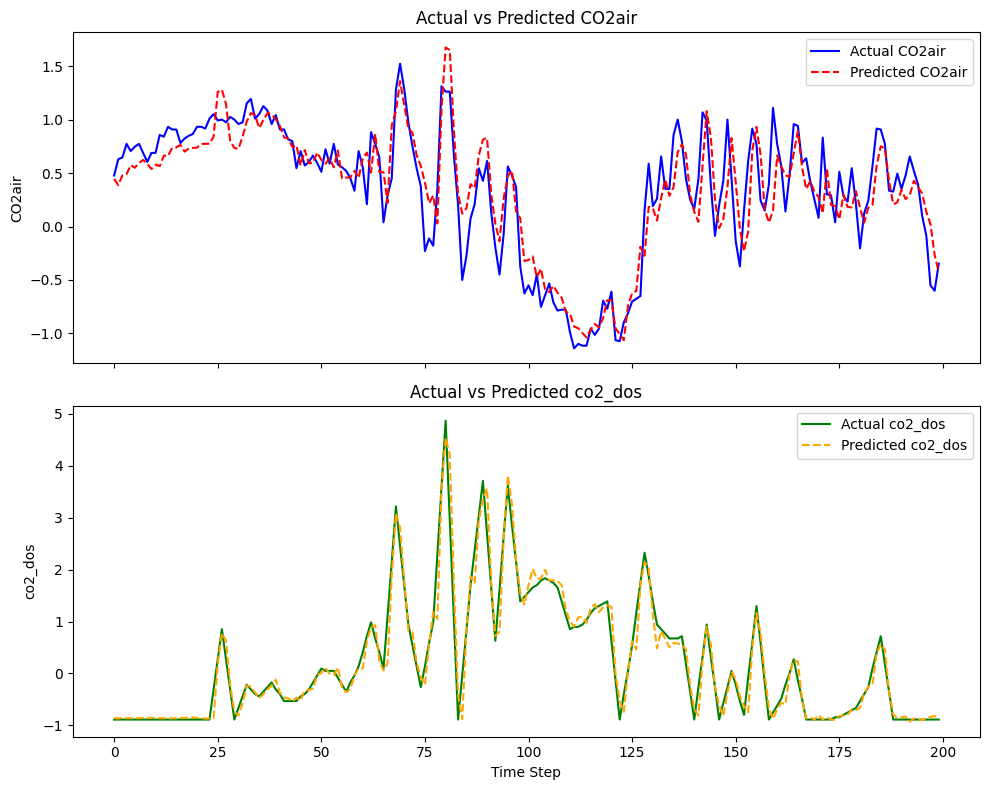

In [83]:
y_pred = model4.predict(X_test)
plot_predictions(y_test, y_pred, start=0, end=200)